In [2]:
!pip install shap

     |████████████████████████████████| 358kB 5.3MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491631 sha256=c5ca27915f0a6130f743f6a3e938986e9b9bedb848f138ad70162930fac70904
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import glob
import matplotlib.image as mpimg
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import shap
from google.colab import drive
from IPython.display import Javascript
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = "/content/drive/MyDrive/SL/src/data/" 
# data_path = "" 
UTK_path = data_path + "UTKFace/"
Landmark_path = data_path + "Landmark/"
plot_path = data_path + 'plots/'

# Create the Dataset

## Create functions

### Extract info from files

In [5]:
def create_landmarks_images_labels_lists(lines):
    labels = []
    landmarks = []
    images = []
    genders=[]
    races=[]
    
    for line in tqdm(lines):
        l = line.split()
        # load the image in memory
        img_file = l[0]
        img = mpimg.imread(UTK_path+img_file+'.chip.jpg')
        images.append(img)

        # extract and order points in (x,y) couples
        points = list(map(int, l[1:]))
        points = np.array(points, dtype=np.int32).reshape((-1, 2))
        landmarks.append(points)

        # extract label 
        label = int(img_file.split('_')[0])
        labels.append(label)

        #extract race
        race= int(img_file.split('_')[1])
        races.append(race)

        #extract gender
        gender= int(img_file.split('_')[2])
        genders.append(gender)
    return landmarks, images, labels, races, genders

def create_landmarks_labels_lists(lines):
    labels = []
    landmarks = []
    genders=[]
    races=[]

    for line in tqdm(lines):
        l = line.split()

        # extract and order points in (x,y) couples
        points = list(map(int, l[1:]))
        points = np.array(points, dtype=np.int32).reshape((-1, 2))
        landmarks.append(points)

        img_file = l[0]
        
        # extract label 
        label = int(img_file.split('_')[0])
        labels.append(label)

        #extract gender
        gender= int(img_file.split('_')[1])
        genders.append(gender)

        #extract race
        race= int(img_file.split('_')[2])
        races.append(race)

    return landmarks, labels, races, genders

def create_landmarks_images_labels_lists_test(cropped_path, lines):
    labels = []
    landmarks = []
    images = []
    genders=[]
    races=[]
    
    for line in tqdm(lines):
        l = line.split()
        # load the image in memory
        if l[1][0]=='(':
          img_file = ' '.join(l[:2])
        else:
          img_file = l[0]

        img = mpimg.imread(cropped_path+img_file)
        images.append(img)

        # extract and order points in (x,y) couples
        if l[1][0]=='(':
          points = list(map(int, l[2:]))
        else:
          points = list(map(int, l[1:]))
        points = np.array(points, dtype=np.int32).reshape((-1, 2))
        landmarks.append(points)

        # extract label 
        label = int(img_file.split('_')[1])
        labels.append(label)

        #extract race
        gender= int(img_file.split('_')[2])
        genders.append(gender)

        #extract race
        race= int(img_file.split('_')[3][0])
        races.append(race)

    return landmarks, images, labels, races, genders

### Wrinkles

In [6]:
def forehead_area(points):
  top_left = [points[18, 0], 0]
  bottom_right = [points[25, 0], points[[19, 24], 1].min()]
  #rect = patches.Rectangle(top_left, bottom_right[0]-top_left[0], bottom_right[1]-top_left[1], linewidth=1, edgecolor='r', facecolor='none')
  #plt.axes().add_patch(rect)
  return (top_left, bottom_right)

def left_eye_area(points):
  top_left=points[17]
  bottom_right=[points[36,0],points[[0,1],1].mean()]
  #rect = patches.Rectangle(top_left, bottom_right[0]-top_left[0], bottom_right[1]-top_left[1], linewidth=1, edgecolor='r', facecolor='none')
  #plt.axes().add_patch(rect)
  return (top_left,bottom_right)

def right_eye_area(points):
  top_right=points[26]
  bottom_left=[points[45,0],points[[15,16],1].mean()]
  #rect = patches.Rectangle(top_right, bottom_left[0]-top_right[0], bottom_left[1]-top_right[1], linewidth=1, edgecolor='r', facecolor='none')
  #plt.axes().add_patch(rect)
  return ([bottom_left[0],top_right[1]],[top_right[0],bottom_left[1]])

def left_cheek_area(points):
  top_left=[points[[36,41],0].mean(),points[41,1]]
  bottom_right=[points[[40,39],0].mean(),points[[33,51],1].mean()]
  #rect = patches.Rectangle(top_left, bottom_right[0]-top_left[0], bottom_right[1]-top_left[1], linewidth=1, edgecolor='r', facecolor='none')
  #plt.axes().add_patch(rect) 
  return (top_left, bottom_right)

def right_cheek_area(points):
  top_right=[points[[46,45],0].mean(),points[46,1]]
  bottom_left=[points[[42,47],0].mean(),points[[33,51],1].mean()]
  #rect = patches.Rectangle(top_right, bottom_left[0]-top_right[0], bottom_left[1]-top_right[1], linewidth=1, edgecolor='r', facecolor='none')
  #plt.axes().add_patch(rect)
  return ([bottom_left[0],top_right[1]],[top_right[0],bottom_left[1]])

def wrinkle_density(edges, slice_1, slice2):
  return (edges[int(slice_1[1]): int(slice2[1]),
                int(slice_1[0]): int(slice2[0])].mean())/255 

def create_wrinkle_df(images, landmarks, method):
    wrinkles = []
    for img, points in zip(images, landmarks):
        # extract wrinkles 
        wrinkle_1_top,   wrinkle_1_bottom   = forehead_area(   points)
        wrinkle_2_1_top, wrinkle_2_1_bottom = left_eye_area(   points)
        wrinkle_2_2_top, wrinkle_2_2_bottom = right_eye_area(  points)
        wrinkle_3_1_top, wrinkle_3_1_bottom = left_cheek_area( points)
        wrinkle_3_2_top, wrinkle_3_2_bottom = right_cheek_area(points)

        # extract the wrinkles using the method given in input
        # edges = cv2.Canny(img, 60, 70)
        try:
          edges = method(img)
          wrinkles.append({
            'wrinkle_1': wrinkle_density(edges, wrinkle_1_top, wrinkle_1_bottom),
            'wrinkle_2': np.mean([wrinkle_density(edges, wrinkle_2_1_top, wrinkle_2_1_bottom),
                                  wrinkle_density(edges, wrinkle_2_2_top, wrinkle_2_2_bottom)]),
            'wrinkle_3': np.mean([wrinkle_density(edges, wrinkle_3_1_top, wrinkle_3_1_bottom),
                                  wrinkle_density(edges, wrinkle_3_2_top, wrinkle_3_2_bottom)])
          })
        except:

          wrinkles.append({
              'wrinkle_1': 0,
              'wrinkle_2': 0,
              'wrinkle_3': 0
          })
    return pd.DataFrame(wrinkles).fillna(0)

### Ratio, Distances, Dispersions

In [7]:
def ratio(points):
    ratio_dict = {}
    
    # Standard Ratio
    chin=points[8]
    nose=points[33]
    left_jaw=points[0]
    left_sof=points[4]
    right_sof=points[12]
    right_jaw=points[16]
    lips=points[[61,62,63,65,66,67]].mean(axis=0)
    left_eye=points[36:42].mean(axis=0)
    right_eye=points[42:48].mean(axis=0)
    head_top=np.array([100,0],dtype='float32')
    middle_eye=(left_eye+right_eye)/2
    
    ratio_dict['ratio_1'] = np.linalg.norm(left_eye-right_eye)/np.linalg.norm(middle_eye-nose)
    ratio_dict['ratio_2'] = np.linalg.norm(left_eye-right_eye)/np.linalg.norm(middle_eye-lips)
    ratio_dict['ratio_3'] = np.linalg.norm(left_eye-right_eye)/np.linalg.norm(middle_eye-chin)
    ratio_dict['ratio_4'] = np.linalg.norm(middle_eye-nose)/np.linalg.norm(middle_eye-lips)
    ratio_dict['ratio_5'] = np.linalg.norm(middle_eye-lips)/np.linalg.norm(middle_eye-chin)
    ratio_dict['ratio_6'] = np.linalg.norm(left_eye-right_eye)/np.linalg.norm(head_top-chin)
    ratio_dict['ratio_7'] = np.linalg.norm(left_sof-right_sof)/np.linalg.norm(head_top-chin)
    
    # Our Distances
    main_points = np.array([chin, nose, left_jaw, 
                            left_sof, right_sof, right_jaw, 
                            lips, middle_eye, head_top])
    norm_vector = np.array([np.abs(right_jaw[0] - left_jaw[0]), 
                            np.abs(head_top[1] - chin[1])])
    main_points /= norm_vector
    
    main_labels = ['chin', 'nose', 
                   'left_jaw', 'left_sof', 'right_sof', 'right_jaw', 
                   'lips', 'middle_eye', 'head_top']
    
    ratio_dict[main_labels[7] + '-' + main_labels[8]] = np.linalg.norm(main_points[7] - main_points[8]) # middle_eye-top_head
    ratio_dict[main_labels[2] + '-' + main_labels[4]] = np.linalg.norm(main_points[2] - main_points[4]) # left_jaw-right_sof
    ratio_dict[main_labels[5] + '-' + main_labels[3]] = np.linalg.norm(main_points[5] - main_points[3]) # right_jaw-left_sof
    ratio_dict[main_labels[0] + '-' + main_labels[3]] = np.linalg.norm(main_points[0] - main_points[3]) # chin-left_sof
    ratio_dict[main_labels[0] + '-' + main_labels[4]] = np.linalg.norm(main_points[0] - main_points[4]) # chin-right_sof
    ratio_dict[main_labels[0] + '-' + main_labels[6]] = np.linalg.norm(main_points[0] - main_points[6]) # chin-lips
    
    # Std for eye, lips and eyebrow
    ratio_dict['std_eye_y'] =  np.mean([(points[36:42,1] / norm_vector[1]).std(), 
                                        (points[42:48,1] / norm_vector[1]).std()])
    ratio_dict['std_eye_x'] =  np.mean([(points[36:42,0] / norm_vector[0]).std(), 
                                        (points[42:48,0] / norm_vector[0]).std()])
    ratio_dict['std_lips_x'] = (points[48:68,0] / norm_vector[0]).std()
    ratio_dict['std_lips_y'] = (points[48:68,1] / norm_vector[1]).std()
    return ratio_dict

def create_ratio_df(landmarks):
    ratios = []
    for points in tqdm(landmarks):
        ratios.append(ratio(points))
    return pd.DataFrame(ratios)

## Create the dataframes

### Load landmarks lines

In [8]:
landmark_files = glob.glob(Landmark_path + '*.txt')
landmark_files.sort()
lines = sum([open(file_name).readlines() for file_name in landmark_files], [])

### Load landmarks, images, labels

In [9]:
#landmarks, images, labels, races, genders = create_landmarks_images_labels_lists(lines)
landmarks, labels, races, genders = create_landmarks_labels_lists(lines)

### Extract the ratios, distances, dispersions

In [10]:
ratio_df = create_ratio_df(landmarks)

### Extract the wrinkles

#### Create the winkles dataframe

In [ ]:
# low_thresh = 30
# high_thresh = 50
# edge_detection_method = lambda _img: cv2.Canny(_img, low_thresh, high_thresh)
# wrinkle_df = create_wrinkle_df(images, landmarks, edge_detection_method)

#### Save the wrinkles to file

In [ ]:
# wrinkle_df.to_csv('wrinkle.csv', index=False)

#### Load the wrinkles from file

In [11]:
wrinkle_df = pd.read_csv(data_path+'wrinkle.csv')

### Encode Races

In [12]:
enc = OneHotEncoder()
encoded_races = enc.fit_transform(np.array(races).reshape((-1, 1))).toarray()

### Create the design dataframe

In [13]:
X = pd.concat([ratio_df, wrinkle_df], axis=1)
X['gender'] = genders
X[['white', 'black', 'asian', 'indian', 'others']] = encoded_races

In [14]:
y = np.digitize(labels, bins=np.array([0, 15, 30, 50]))
# y = np.digitize(labels, bins=np.array([0, 10, 18]))

### Split in train and test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Print the dataframes

In [16]:
wrinkle_df

,wrinkle_1,wrinkle_2,wrinkle_3
0,0.077315,0.117935,0.158641
1,0.007500,0.154004,0.090443
2,0.141791,0.179932,0.124555
3,0.104369,0.128764,0.062907
4,0.016722,0.222772,0.161676
...,...,...,...
23702,0.078732,0.213159,0.162205
23703,0.146333,0.250069,0.186364
23704,0.231504,0.270136,0.203972
23705,0.205721,0.270677,0.198737


In [ ]:
ratio_df

,ratio_1,ratio_2,ratio_3,ratio_4,ratio_5,ratio_6,ratio_7,middle_eye-head_top,left_jaw-right_sof,right_jaw-left_sof,chin-left_sof,chin-right_sof,chin-lips,std_eye_y,std_eye_x,std_lips_x,std_lips_y
0,1.543410,1.097104,0.633795,0.710831,0.577698,0.432152,0.881820,0.318608,1.047148,1.047204,0.486202,0.442190,0.288083,0.008679,0.050892,0.107348,0.025539
1,2.112302,1.197716,0.660367,0.567019,0.551355,0.441475,0.804744,0.331865,1.015605,1.028432,0.407486,0.533903,0.300291,0.023433,0.057228,0.088407,0.042057
2,1.513366,1.056457,0.644400,0.698085,0.609964,0.438219,0.822786,0.320320,1.043540,0.997012,0.442218,0.498479,0.266595,0.020116,0.055182,0.103478,0.046744
3,1.341733,0.723922,0.486105,0.539543,0.671488,0.346437,0.605399,0.287925,1.016067,0.968786,0.437863,0.481983,0.246162,0.023030,0.058518,0.082944,0.084074
4,1.458671,0.950596,0.580138,0.651687,0.610288,0.401263,0.774756,0.308653,1.010499,1.029051,0.500645,0.455319,0.270063,0.012126,0.052678,0.108675,0.057147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23702,1.210715,0.887391,0.525607,0.732948,0.592306,0.372043,0.749359,0.292353,1.011152,1.053951,0.522151,0.443950,0.289803,0.017366,0.053627,0.114817,0.043803
23703,1.551792,1.030495,0.621273,0.664068,0.602888,0.432804,0.759351,0.308479,1.008547,1.011487,0.455236,0.452228,0.277755,0.020488,0.056518,0.091337,0.030397
23704,1.262105,0.851673,0.508688,0.674804,0.597281,0.363802,0.801057,0.284832,1.041684,1.059205,0.444111,0.530624,0.289658,0.012523,0.048018,0.072992,0.024998
23705,1.114413,0.779037,0.445411,0.699056,0.571746,0.316247,0.681959,0.291108,0.994775,1.034327,0.442083,0.545543,0.304704,0.017348,0.047596,0.093038,0.043797


In [ ]:
X

,ratio_1,ratio_2,ratio_3,ratio_4,ratio_5,ratio_6,ratio_7,middle_eye-head_top,left_jaw-right_sof,right_jaw-left_sof,chin-left_sof,chin-right_sof,chin-lips,std_eye_y,std_eye_x,std_lips_x,std_lips_y,wrinkle_1,wrinkle_2,wrinkle_3,gender,white,black,asian,indian,others
0,1.543410,1.097104,0.633795,0.710831,0.577698,0.432152,0.881820,0.318608,1.047148,1.047204,0.486202,0.442190,0.288083,0.008679,0.050892,0.107348,0.025539,0.077315,0.117935,0.158641,0,0.0,0.0,1.0,0.0,0.0
1,2.112302,1.197716,0.660367,0.567019,0.551355,0.441475,0.804744,0.331865,1.015605,1.028432,0.407486,0.533903,0.300291,0.023433,0.057228,0.088407,0.042057,0.007500,0.154004,0.090443,0,0.0,0.0,1.0,0.0,0.0
2,1.513366,1.056457,0.644400,0.698085,0.609964,0.438219,0.822786,0.320320,1.043540,0.997012,0.442218,0.498479,0.266595,0.020116,0.055182,0.103478,0.046744,0.141791,0.179932,0.124555,0,0.0,0.0,1.0,0.0,0.0
3,1.341733,0.723922,0.486105,0.539543,0.671488,0.346437,0.605399,0.287925,1.016067,0.968786,0.437863,0.481983,0.246162,0.023030,0.058518,0.082944,0.084074,0.104369,0.128764,0.062907,1,0.0,0.0,1.0,0.0,0.0
4,1.458671,0.950596,0.580138,0.651687,0.610288,0.401263,0.774756,0.308653,1.010499,1.029051,0.500645,0.455319,0.270063,0.012126,0.052678,0.108675,0.057147,0.016722,0.222772,0.161676,1,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23702,1.210715,0.887391,0.525607,0.732948,0.592306,0.372043,0.749359,0.292353,1.011152,1.053951,0.522151,0.443950,0.289803,0.017366,0.053627,0.114817,0.043803,0.078732,0.213159,0.162205,1,1.0,0.0,0.0,0.0,0.0
23703,1.551792,1.030495,0.621273,0.664068,0.602888,0.432804,0.759351,0.308479,1.008547,1.011487,0.455236,0.452228,0.277755,0.020488,0.056518,0.091337,0.030397,0.146333,0.250069,0.186364,1,1.0,0.0,0.0,0.0,0.0
23704,1.262105,0.851673,0.508688,0.674804,0.597281,0.363802,0.801057,0.284832,1.041684,1.059205,0.444111,0.530624,0.289658,0.012523,0.048018,0.072992,0.024998,0.231504,0.270136,0.203972,1,1.0,0.0,0.0,0.0,0.0
23705,1.114413,0.779037,0.445411,0.699056,0.571746,0.316247,0.681959,0.291108,0.994775,1.034327,0.442083,0.545543,0.304704,0.017348,0.047596,0.093038,0.043797,0.205721,0.270677,0.198737,1,1.0,0.0,0.0,0.0,0.0


In [ ]:
y

array([1, 1, 1, ..., 4, 4, 4])

# Plot Images, Features and Correlations

### Plot age class distribution

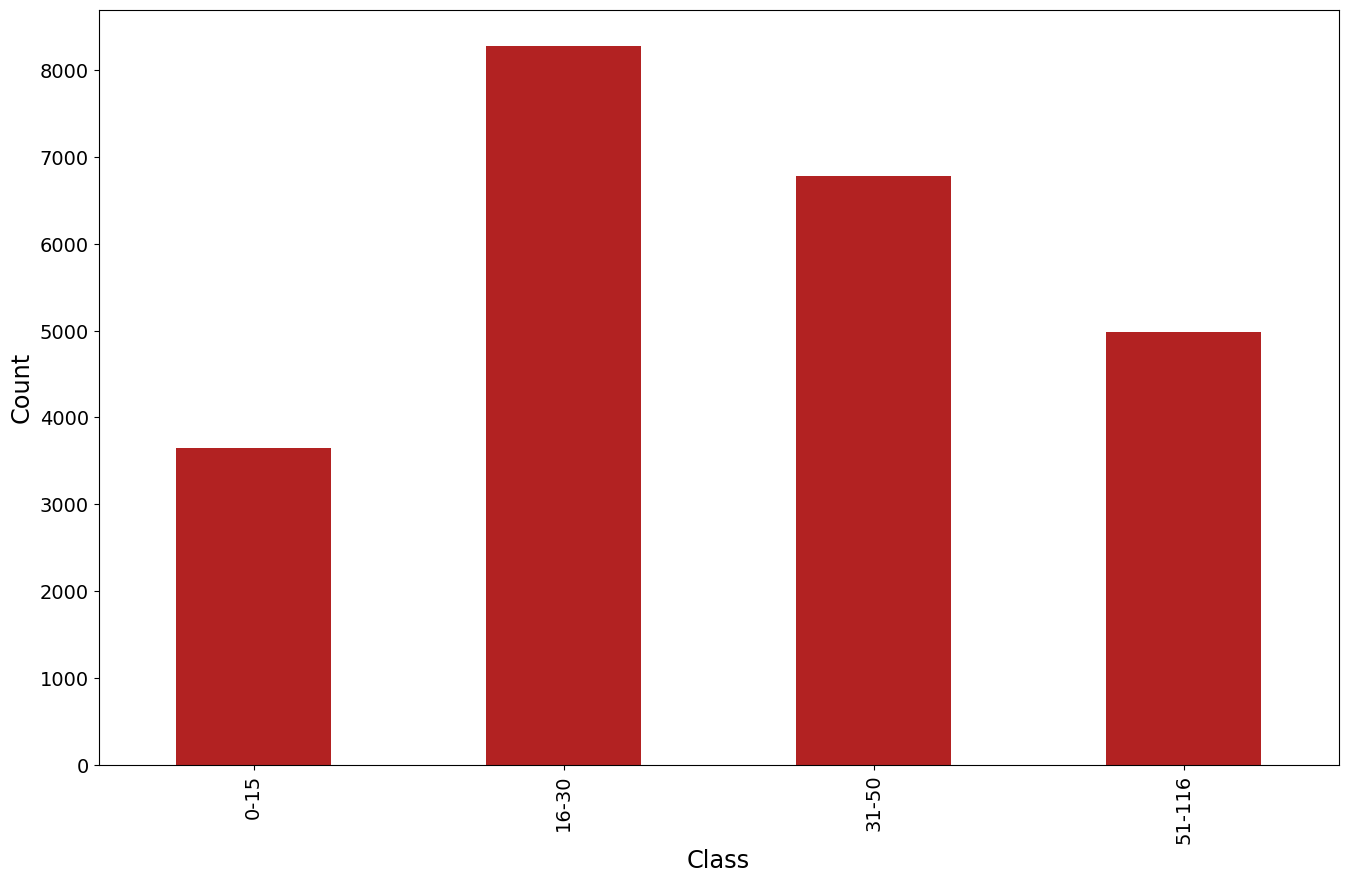

In [ ]:
_df = X.drop(columns=['gender', 'white', 'black', 'asian', 'indian', 'others']).copy()
_df['Class'] = y
plt.figure(figsize=(16, 10), dpi=100)
_df.groupby('Class').size().plot.bar(color='firebrick')
plt.xticks(range(4), ['0-15', '16-30', '31-50', '51-116']);
plt.xlabel('Class', fontsize='xx-large')
plt.ylabel('Count', fontsize='xx-large')
plt.tick_params(axis='both', labelsize=14)
# plt.title('Class Distribution', fontsize='xx-large')
plt.savefig(plot_path +"classDistribution")
plt.show()

### Feature age correlation

In [ ]:
_df = X.drop(columns=['gender', 'white', 'black', 'asian', 'indian', 'others']).copy()
_df['age'] = labels
# _df = _df.melt(id_vars='age')
fig, axs = plt.subplots(4, 5, figsize=(50, 40), dpi=100)
for i, col in tqdm(enumerate(_df)):
  if col=='age':
    continue
  sns.lineplot(data=_df, x='age', y=col, ax=axs[i//5, i%5])
  axs[i//5, i%5].tick_params(axis='both', labelsize=16)
  axs[i//5, i%5].set_ylabel(col,   fontsize=22)
  axs[i//5, i%5].set_xlabel('Age', fontsize=22)
plt.savefig(plot_path +"featureAgeCorrelation")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Parameters Optimization

## Canny's Parameters

In [ ]:
thresh_values = np.arange(30, 200, 10)
results = []
for low_t in tqdm(thresh_values):
  for high_t in thresh_values[thresh_values > low_t]:
    edge_detection_method = lambda _img: cv2.Canny(_img, low_t, high_t)
    wrinkle_df = create_wrinkle_df(images, landmarks, edge_detection_method)
    X = pd.concat([ratio_df, wrinkle_df], axis=1)
    X['race'] = races
    X['gender'] = genders
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    print(f'{low_t, high_t}')
    clf = RandomForestClassifier(criterion='gini', n_estimators=200, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = np.mean(y_pred == y_test)
    results.append({'low_t': low_t, 
                    'high_t': high_t,
                    'acc': acc})

  0%|          | 0/17 [00:00<?, ?it/s]


NameError: ignored

In [ ]:
canny_results_df = pd.DataFrame(results)
canny_results_df.sort_values('acc', ascending=False).to_csv('canny_results.csv', index=False)
canny_results_df.sort_values('acc', ascending=False)

KeyError: ignored

## Model Parameters

In [ ]:
%%time
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.5,1,2,0.1,0.01,0.001,0.0001],
                     'C': [0.1,1, 10, 100,150,200,220]}]
                    #{'kernel': ['linear'], 'C': [0.1,1, 10, 100]},
                    #{'kernel':['poly'],'C': [0.1,1, 10, 100],'degree':[3,4,5]},
                    #{'kernel':['sigmoid'],'C': [0.1,1, 10, 100]}]

clf = GridSearchCV(SVC(), tuned_parameters, cv=5, n_jobs=-1, verbose=10)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)


# SVC - Model Training

In [17]:
svc = SVC(C=100, gamma=1, kernel='rbf', random_state=42)
svc.fit(X_train, y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

# Test on UTK Dataset

## Performance Evaluation

In [ ]:
y_pred=svc.predict(X_test)
print('Test  Accuracy:', np.mean(y_pred==y_test))
print('Train Accuracy:', np.mean(svc.predict(X_train)==y_train))
print(classification_report(y_test, y_pred))

## Evaluation Plots

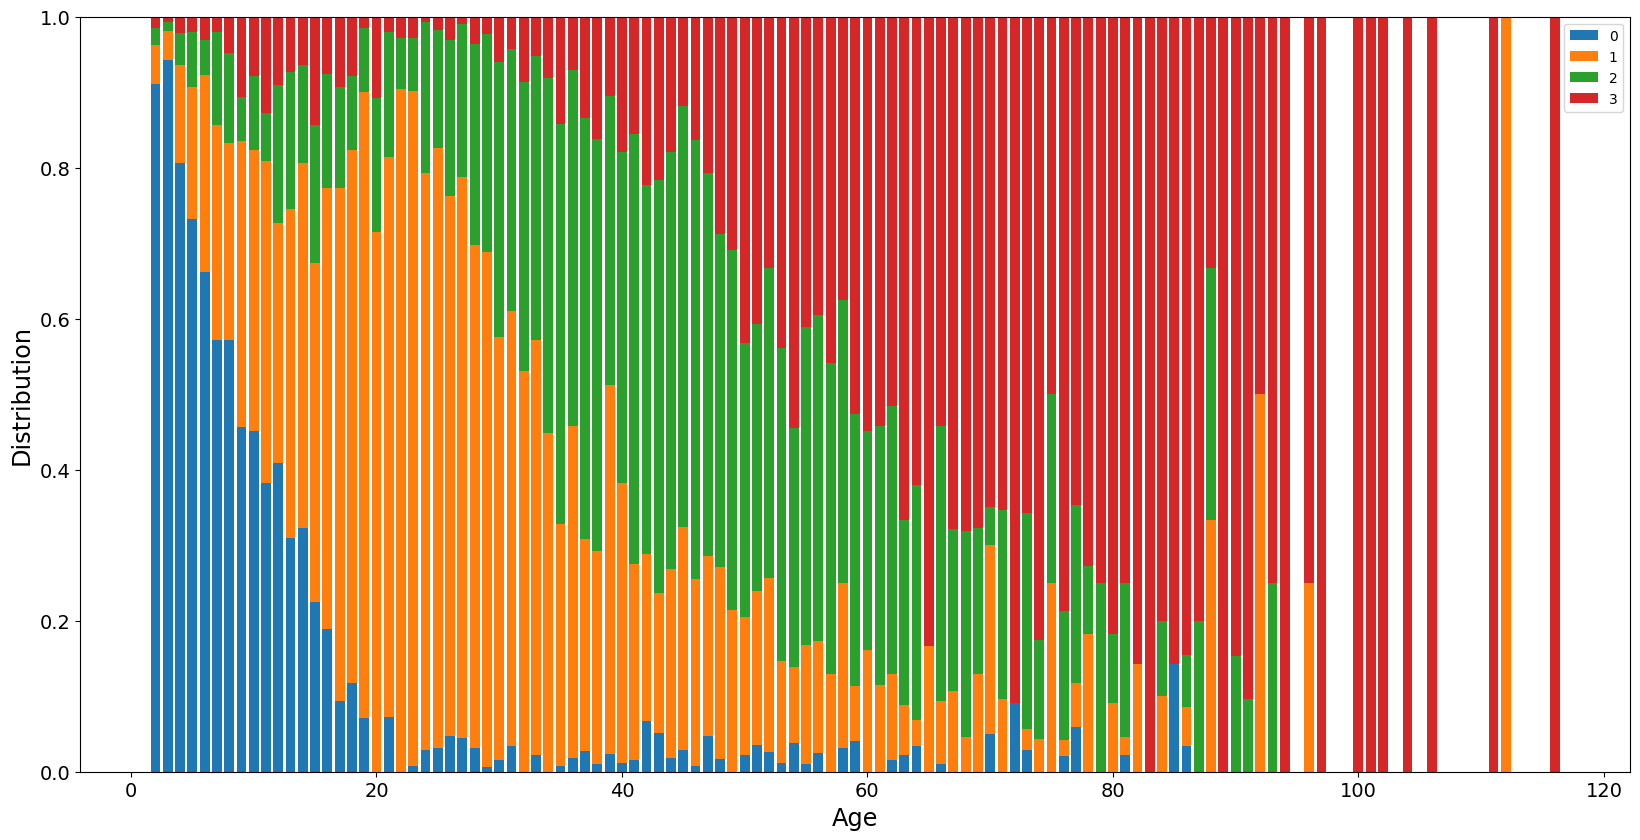

In [ ]:
np_labels = np.array(labels)
step = 1
test_labels = np_labels[X_test.index]
pred_encoder = OneHotEncoder()
encoded_races = pred_encoder.fit_transform(np.array(y_pred).reshape((-1, 1))).toarray()
ages_pred_df = pd.DataFrame({'age': np.digitize(test_labels, np.arange(0, 130, step))})
ages_pred_df[list(map(str, range(encoded_races.shape[1])))] = encoded_races
age_class_prediction = ages_pred_df.groupby('age').mean()
axis_sum = age_class_prediction.sum(1).copy()
fig, ax = plt.subplots(figsize=(20, 10), dpi=100)
bottom = np.zeros_like(axis_sum)
for col in age_class_prediction:
  age_class_prediction[col] /= axis_sum
for col in age_class_prediction:
  ax.bar(age_class_prediction.index*step, age_class_prediction[col], label=col, bottom=bottom)
  bottom += age_class_prediction[col]
ax.legend()
plt.tick_params(axis='both', labelsize=14)
plt.ylabel('Distribution', fontsize='xx-large')
plt.xlabel('Age', fontsize='xx-large')
plt.savefig(plot_path+'agePredictionDistribution')
plt.show()

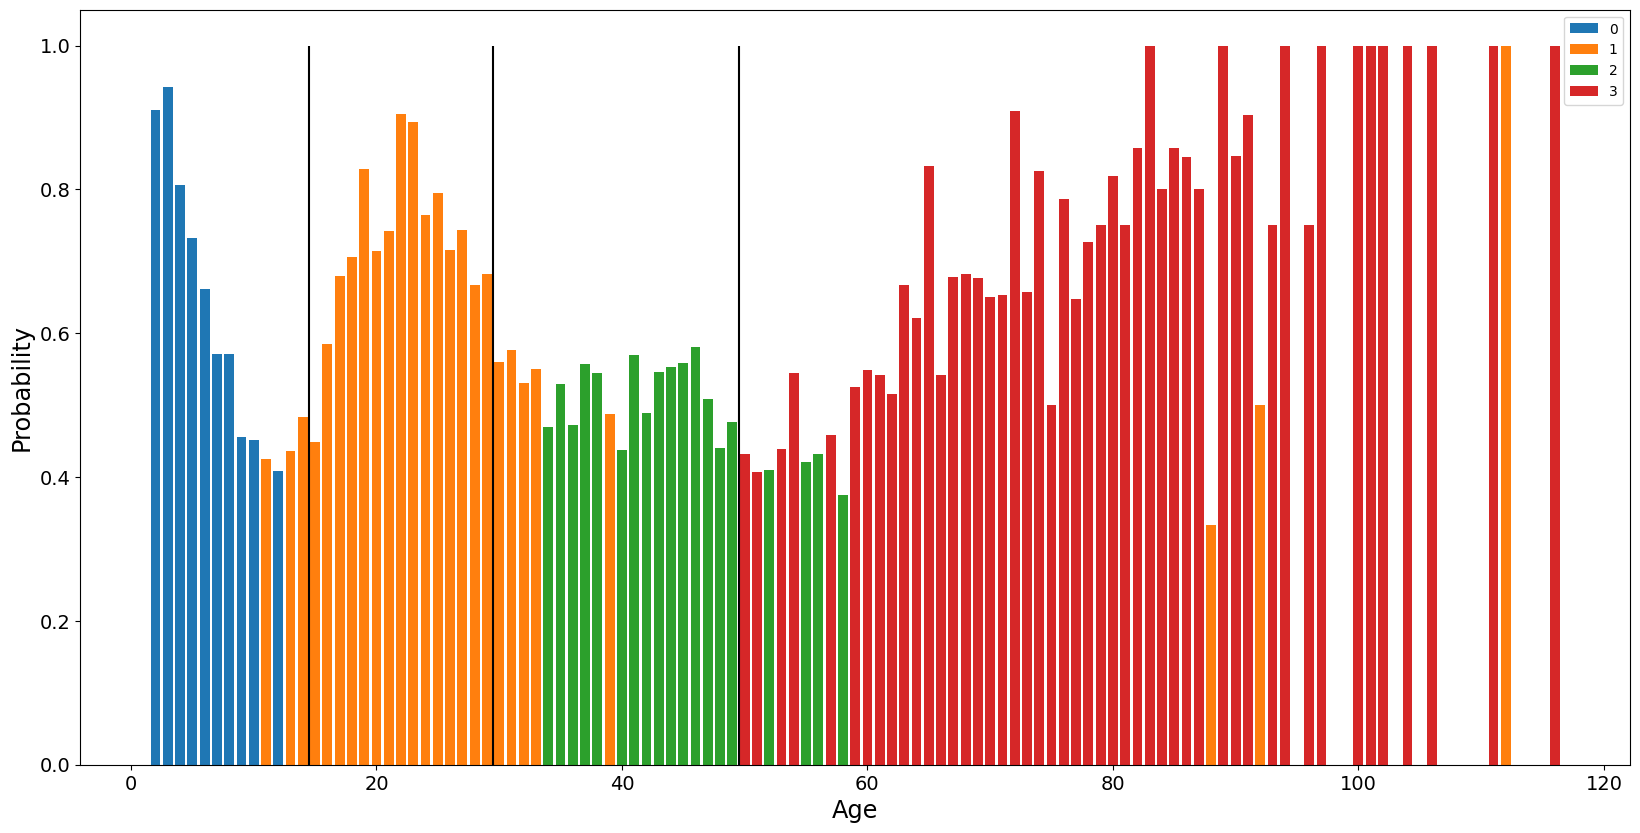

In [ ]:
age_class_prediction = ages_pred_df.groupby('age').mean()
axis_sum = age_class_prediction.sum(1).copy()
fig, ax = plt.subplots(figsize=(20, 10), dpi=100)
bottom = np.zeros_like(axis_sum)
for col in age_class_prediction:
  ax.bar(age_class_prediction.index, 
         age_class_prediction[col]*(age_class_prediction.idxmax('columns') == col),
         label=col, bottom=bottom)
ax.legend()
plt.tick_params(axis='both', labelsize=14)
plt.ylabel('Probability', fontsize='xx-large')
plt.xlabel('Age', fontsize='xx-large')
ax.vlines([14.5, 29.5, 49.5], 0, 1)
plt.savefig(plot_path+'agePredictionDistribution2')
plt.show()

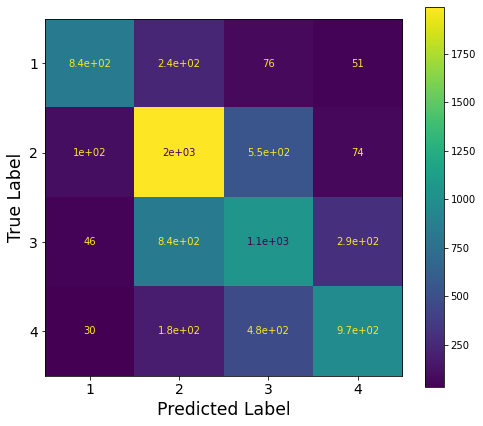

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))
plot_confusion_matrix(svc, X_test, y_test, ax=ax)
ax.set_ylabel('True Label', fontsize='xx-large')
ax.set_xlabel('Predicted Label', fontsize='xx-large')
plt.tick_params(axis='both', labelsize=14)
plt.savefig(plot_path + 'confusionMatrix')
plt.show()

## IML: Shap

In [18]:
def multi_shap_force(clf, X_df, index,
                     explainer, shap_values):
    shap.initjs()
    # Create dict for mapping class labels
    label_dict = {0: 'Class: 0-15, Child',
                  1: 'Class: 16-30, Young Adult',
                  2: 'Class: 31-50, Adult',
                  3: 'Class: 51+, Elderly'}
    X_df = X_df.copy().round(3)
    # Print the force plots
    for i in range(4):
      print(label_dict[i])
      shap.force_plot(explainer.expected_value[i],
                      shap_values[i][index],
                      X_df.iloc[[index],:], 
                      matplotlib=True,
                      show=True
                      )

In [ ]:
# explainer = shap.KernelExplainer(svc.decision_function, np.zeros_like(X_test[:1]))
explainer = shap.KernelExplainer(svc.decision_function, X_train.median())
# explainer = shap.KernelExplainer(svc.decision_function, X_train[:10])
shap_values = explainer.shap_values(X_test[:50])

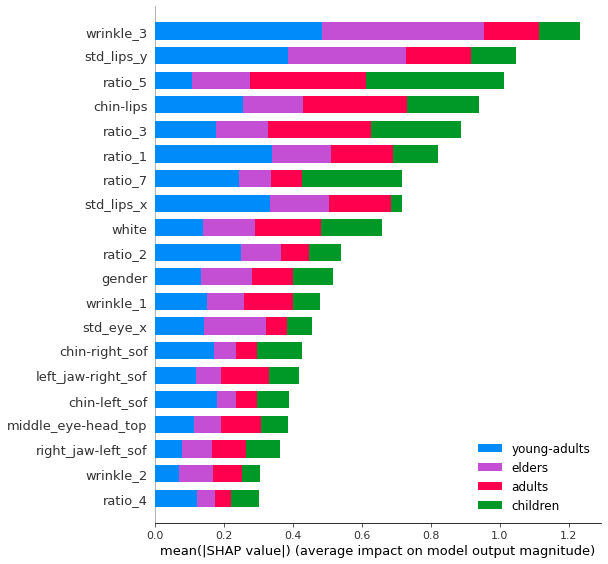

In [ ]:
shap.summary_plot(shap_values, X_test[:50], show=False, class_names=['children', 'young-adults', 'adults', 'elders'])
plt.savefig(plot_path + 'test_shap')

## IML: Feature-Class Correlations

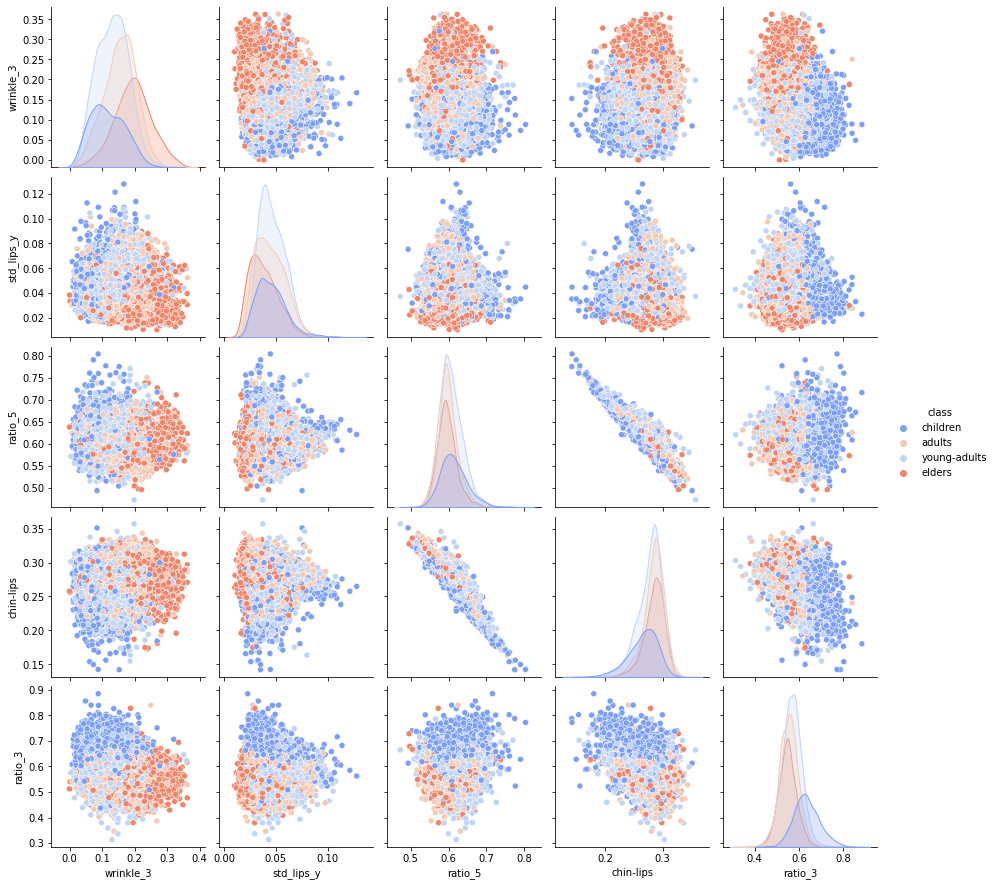

In [ ]:
df_pair = X_train[['wrinkle_3', 'std_lips_y', 'ratio_5', 'chin-lips', 'ratio_3']].copy()
class_label = {1:'children', 2:'young-adults', 3:'adults', 4:'elders'}
df_pair['class'] = list(map(lambda x: class_label[x], y_train))
palette = sns.color_palette('coolwarm', n_colors=4)
palette_dict = {'children':palette[0], 'young-adults':palette[1], 'adults':palette[2], 'elders':palette[3]}
sns.pairplot(data=df_pair, hue='class', palette=palette_dict)
plt.savefig(plot_path + 'featureClassCorrelation')
plt.show()

# Test on Our Dataset

## Create the Dataset

### Load the landmark lines

In [19]:
lines_our = open(data_path + 'our_landmark.txt').readlines()
andrea_pos = 4

### Load landmarks, imags, labels, etc.

In [20]:
landmarks_our, images_our, labels_our, races_our, genders_our = create_landmarks_images_labels_lists_test(data_path + 'cropped_dataset/', lines_our)

### Extract ratios

In [21]:
ratio_df_test = create_ratio_df(landmarks_our)

### Encode races

In [22]:
encoded_races_test = enc.transform(np.array(races_our).reshape((-1, 1))).toarray()

### Extract wrinkles

In [23]:
low_thresh = 30
high_thresh = 50
edge_detection_method = lambda _img: cv2.Canny(cv2.blur(_img, (1,1)), low_thresh, high_thresh)
wrinkle_df_test = create_wrinkle_df(images_our, landmarks_our, edge_detection_method)

Mean of empty slice.
invalid value encountered in double_scalars


### Create the design dataframe

In [24]:
X_test_our = pd.concat([ratio_df_test, wrinkle_df_test], axis=1)
X_test_our['gender'] = genders_our
X_test_our[['white', 'black', 'asian', 'indian', 'others']] = encoded_races_test

In [25]:
y_test_our = np.digitize(labels_our, bins=np.array([0, 15, 30, 50]))

## Print the dataframes

In [26]:
X_test_our

,ratio_1,ratio_2,ratio_3,ratio_4,ratio_5,ratio_6,ratio_7,middle_eye-head_top,left_jaw-right_sof,right_jaw-left_sof,chin-left_sof,chin-right_sof,chin-lips,std_eye_y,std_eye_x,std_lips_x,std_lips_y,wrinkle_1,wrinkle_2,wrinkle_3,gender,white,black,asian,indian,others
0,1.357690,0.933651,0.620373,0.687676,0.664460,0.360240,0.623903,0.498336,1.006014,1.004930,0.431997,0.483510,0.198528,0.020539,0.064685,0.100623,0.022913,0.050959,0.144066,0.066826,1,1.0,0.0,0.0,0.0,0.0
1,1.322090,0.855058,0.602547,0.646747,0.704685,0.359021,0.605872,0.496015,0.998624,0.998163,0.448385,0.479627,0.180281,0.015583,0.062762,0.111791,0.040117,0.010470,0.090778,0.041681,0,1.0,0.0,0.0,0.0,0.0
2,1.104728,0.835823,0.549202,0.756586,0.657080,0.336867,0.604651,0.422727,0.999688,0.965845,0.530461,0.414792,0.220432,0.025281,0.059696,0.097842,0.036753,0.022060,0.122388,0.052712,0,1.0,0.0,0.0,0.0,0.0
3,1.817867,1.139658,0.690922,0.626921,0.606254,0.396113,0.666118,0.507347,0.938096,0.997720,0.394689,0.435583,0.235364,0.029535,0.063863,0.079607,0.030419,0.274330,0.280252,0.193057,0,1.0,0.0,0.0,0.0,0.0
4,1.163172,0.861412,0.567774,0.740572,0.659120,0.357633,0.676724,0.493392,1.039298,0.994087,0.489406,0.439181,0.219951,0.017305,0.053931,0.106914,0.021616,0.168831,0.355449,0.307592,0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,1.476199,1.076444,0.654704,0.729200,0.608210,0.392939,0.735834,0.445908,1.024128,1.054322,0.440885,0.507428,0.236841,0.018673,0.060948,0.105449,0.031252,0.200774,0.266319,0.160709,0,1.0,0.0,0.0,0.0,0.0
77,1.652906,1.173177,0.663673,0.709766,0.565706,0.408090,0.739752,0.441011,1.007069,1.049924,0.442616,0.485270,0.272549,0.019234,0.056117,0.124061,0.032688,0.105162,0.267919,0.149511,0,1.0,0.0,0.0,0.0,0.0
78,1.199544,0.951054,0.674666,0.792846,0.709387,0.435680,0.776612,0.361368,1.052515,0.992488,0.585709,0.366074,0.190317,0.018892,0.067154,0.137444,0.053683,0.179936,0.000000,0.281521,1,1.0,0.0,0.0,0.0,0.0
79,1.627393,1.019069,0.526234,0.626197,0.516387,0.322825,0.657370,0.482908,0.968247,1.047563,0.454791,0.484247,0.302465,0.014790,0.050301,0.109317,0.043738,0.000000,0.000000,0.000000,0,1.0,0.0,0.0,0.0,0.0


In [ ]:
y_test_our

array([2, 2, 2, 1, 4, 1, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 4, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 1, 3, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 4, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2])

## Performance Evaluation

In [27]:
y_pred_our = svc.predict(X_test_our)
print('Accuracy:', np.mean(y_pred_our==y_test_our))
print(classification_report(y_test_our, y_pred_our))

Accuracy: 0.345679012345679
              precision    recall  f1-score   support

           1       0.25      1.00      0.40        16
           2       0.91      0.18      0.30        55
           3       0.33      0.33      0.33         3
           4       0.33      0.14      0.20         7

    accuracy                           0.35        81
   macro avg       0.46      0.41      0.31        81
weighted avg       0.71      0.35      0.31        81



## Model Interpretation using SHAP

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

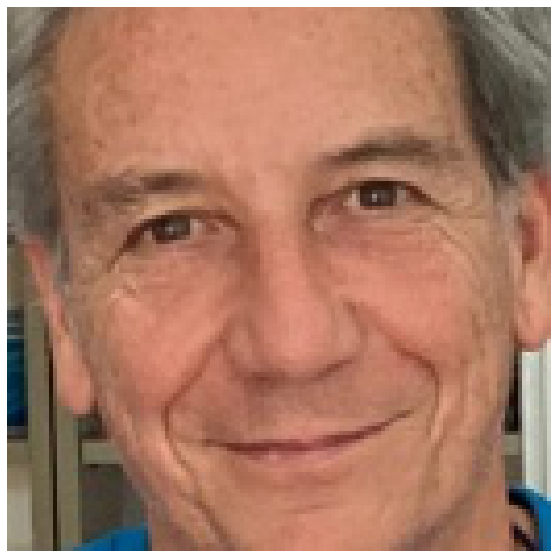

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(images_our[4])
plt.axis('off')
plt.show();

In [41]:
explainer_test = shap.KernelExplainer(svc.decision_function, X_train.median())
shap_values_test = explainer_test.shap_values(X_test_our[:6])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Class: 0-15, Child


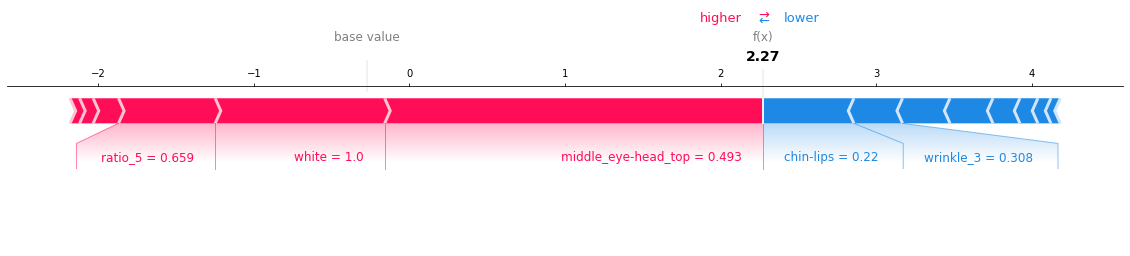

Class: 16-30, Young Adult


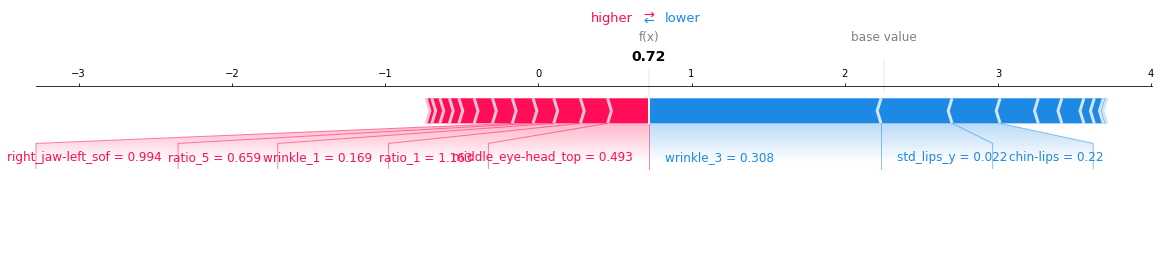

Class: 31-50, Adult


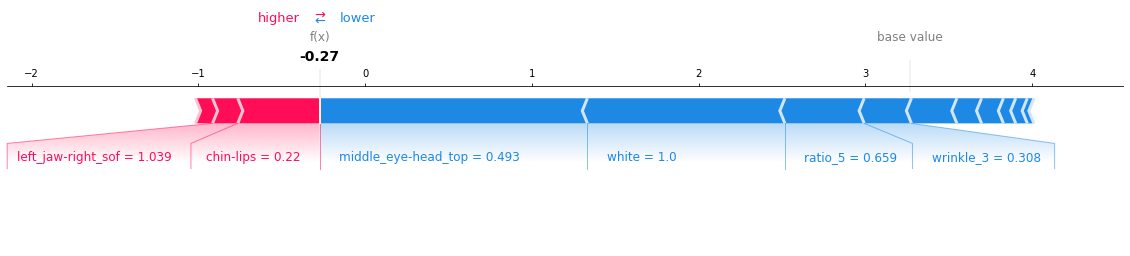

Class: 51+, Elderly


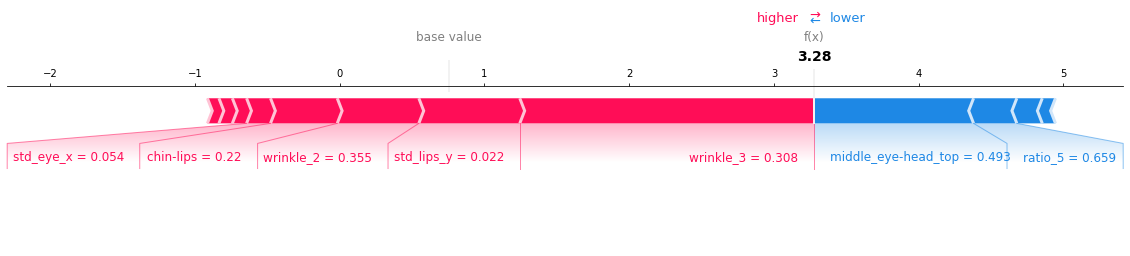

In [42]:
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)
multi_shap_force(svc, X_test_our, 4, explainer_test, shap_values_test)